DATA LOADING

In [8]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.io.wavfile import read
import scipy.io

# script importing
from peak_picking import *
from pca import *
from gradient_delay import *

# SFOAE data loading
mat_SFOAE = scipy.io.loadmat(
    'data/SFOAE/sfoae40dBg130TM45R19rs2.mat')

freq_SFOAE = mat_SFOAE['Fvect'].flatten()  # frequency axis
SFOAE = mat_SFOAE['oaeNum40'].flatten()  # SFOAE wave
CRcomp = mat_SFOAE['CRc40'].flatten()  # CR component
NLcomp = mat_SFOAE['Yunl40'].flatten()  # NL component

freq_range_SFOAE = np.size(freq_SFOAE)  # maximum index on the frequency axis

CALCULATING NEEDED VALUES

SFOAE

In [9]:
# peak picking
maximas_SFOAE = findLocalMaxima(np.real(20*np.log10(SFOAE)))
shift = 1  # 3 points around all peaks (the peak is included)
ext_maximas_SFOAE = peakNeighbours(maximas_SFOAE, shift, freq_range_SFOAE)

group_delay_SFOAE = calcDelay(freq_SFOAE, SFOAE)


CR COMPONENT

In [10]:
freq_range_CR = freq_range_SFOAE
freq_CR = freq_SFOAE

# peak picking
maximas_CR = findLocalMaxima(np.real(20*np.log10(CRcomp)))
shift = 1  # 3 points around all peaks (the peak is included)
ext_maximas_CR = peakNeighbours(maximas_CR, shift, freq_range_CR)

group_delay_CR = calcDelay(freq_CR, CRcomp)


NL COMPONENT

In [11]:
freq_range_NL = freq_range_SFOAE
freq_NL = freq_SFOAE

# peak picking
maximas_NL = findLocalMaxima(np.real(20*np.log10(NLcomp)))
shift = 1  # 3 points around all peaks (the peak is included)
ext_maximas_NL = peakNeighbours(maximas_NL, shift, freq_range_NL)

group_delay_NL = calcDelay(freq_NL, NLcomp)


ISOLATED INTENSITY

In [12]:
from isoint import *

ISOINT_start, ISOINT_stop, ISOINT_step = 1000, 3200, 200

freq_ISOINT_list = []
GD_ISOINT_list = []
max_idx_ISOINT_list = []

for i in range(ISOINT_start, ISOINT_stop + 1, ISOINT_step):
    filename = f"data/isointFT/isoint_{i}Hz_Level_40dB_TM45130.mat"
    freq_ISOINT, group_delay_ISOINT, max_idx_ISOINT = processIsoInt(filename)

    freq_ISOINT_list.append(freq_ISOINT)
    GD_ISOINT_list.append(group_delay_ISOINT)
    max_idx_ISOINT_list.append(max_idx_ISOINT)

PLOTTING

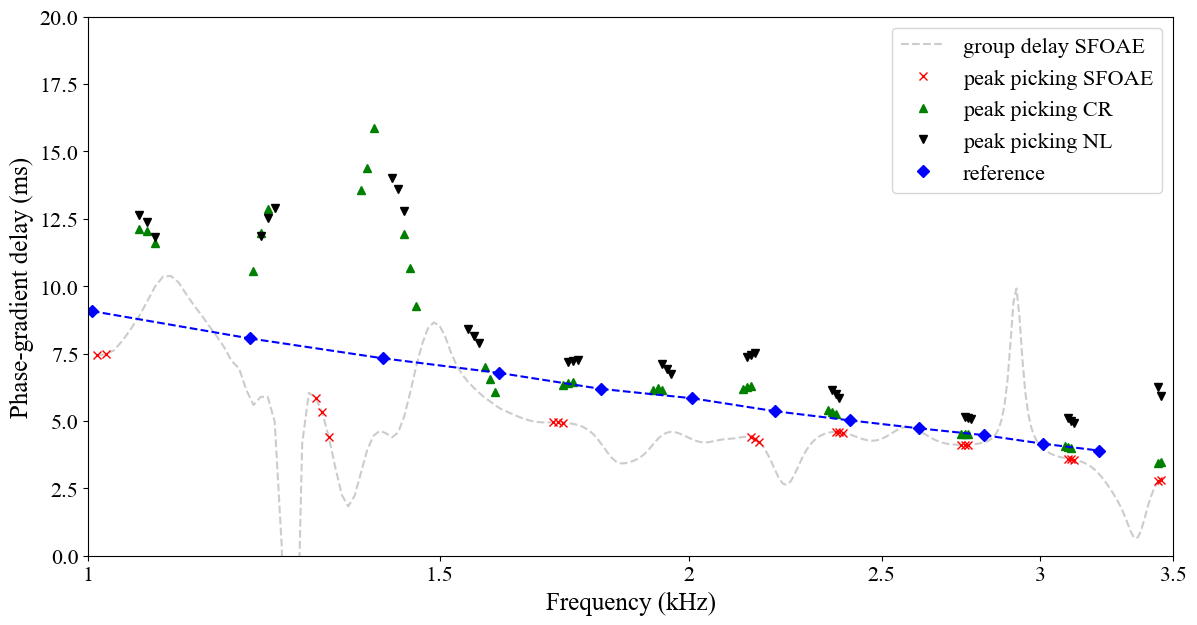

In [14]:
from matplotlib.ticker import FixedLocator, FixedFormatter

fig, ax = plt.subplots(figsize=(14, 7))

# multiplying by 1000 because of the transfer to miliseconds
ax.plot(freq_SFOAE/1000, 1000*group_delay_SFOAE, '0.8',
        linestyle='--', label='group delay SFOAE')
ax.plot(freq_SFOAE[ext_maximas_SFOAE]/1000, 1000*group_delay_SFOAE[ext_maximas_SFOAE],
        "rx", label='peak picking SFOAE')

ax.plot(freq_CR[ext_maximas_CR]/1000, 1000*group_delay_CR[ext_maximas_CR],
        "g^", label='peak picking CR')

ax.plot(freq_NL[ext_maximas_NL]/1000, 1000*group_delay_NL[ext_maximas_NL],
        "kv", label='peak picking NL')

# reference values
for i, freq_ISOINT in enumerate(freq_ISOINT_list):
    max_idx = max_idx_ISOINT_list[i]
    grad_delay_ISOINT = GD_ISOINT_list[i]
    ax.plot(freq_ISOINT[max_idx]/1000, 1000*grad_delay_ISOINT[max_idx],
            "bD", label='reference' if i == 0 else None)
    if i > 0:  # connect points starting from the second point
        ax.plot([freq_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]]/1000, freq_ISOINT[max_idx]/1000],
                [1000*GD_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]],
                    1000*grad_delay_ISOINT[max_idx]],
                "b--")

# # for comparing cochlear filter with the NL group delay
# ax.plot(freq_NL[compare_NL-compare_region:compare_NL+compare_region+1], 1000*group_delay_NL[compare_NL-compare_region:compare_NL+compare_region+1], 'k',
#         linestyle='--', label='group delay NL (ROI)')
# # for comparing cochlear filter with the CR group delay
# ax.plot(freq_CR[compare_CR-compare_region:compare_CR+compare_region+1], 1000*group_delay_CR[compare_CR-compare_region:compare_CR+compare_region+1], 'g',
#         linestyle='--', label='group delay CR (ROI)')

ax.set_xscale('log')
ax.set_xlim([1, 3.5])
# Customize the tick labels on the x-axis
x_ticks = [1, 1.5, 2, 2.5, 3, 3.5]
ax.xaxis.set_major_locator(FixedLocator(x_ticks))
ax.xaxis.set_major_formatter(FixedFormatter(x_ticks))
ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_ylim([0, 20])
ax.set_xlabel('Frequency (kHz)', fontdict={"fontsize": 18})
ax.set_ylabel('Phase-gradient delay (ms)', fontdict={"fontsize": 18})
ax.legend(fontsize=16)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
# plt.savefig('Group_delays_40_dB.png')
